In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import torch
import matplotlib.pyplot as plt

### Load Data

In [2]:
data_train = pd.read_csv('Google_Stock_Price_Train.csv.xls', thousands=',')
data_train.shape

(1258, 6)

In [3]:
data_test = pd.read_csv('Google_Stock_Price_Test.csv.xls',thousands=',')
data_test

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,1657300
1,1/4/2017,788.36,791.34,783.16,786.90,1073000
2,1/5/2017,786.08,794.48,785.02,794.02,1335200
3,1/6/2017,795.26,807.90,792.20,806.15,1640200
4,1/9/2017,806.40,809.97,802.83,806.65,1272400
5,1/10/2017,807.86,809.13,803.51,804.79,1176800
6,1/11/2017,805.00,808.15,801.37,807.91,1065900
7,1/12/2017,807.14,807.39,799.17,806.36,1353100
8,1/13/2017,807.48,811.22,806.69,807.88,1099200
9,1/17/2017,807.08,807.14,800.37,804.61,1362100


In [4]:
data = pd.concat([data_train,data_test], axis=0 )
data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,7380500
1,1/4/2012,331.27,333.87,329.08,666.45,5749400
2,1/5/2012,329.83,330.75,326.89,657.21,6590300
3,1/6/2012,328.34,328.77,323.68,648.24,5405900
4,1/9/2012,322.04,322.29,309.46,620.76,11688800
...,...,...,...,...,...,...
15,1/25/2017,829.62,835.77,825.06,835.67,1494500
16,1/26/2017,837.81,838.00,827.01,832.15,2973900
17,1/27/2017,834.71,841.95,820.44,823.31,2965800
18,1/30/2017,814.66,815.84,799.80,802.32,3246600


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
data = data.iloc[:,1:]
data

,Open,High,Low,Close,Volume
0,325.25,332.83,324.97,663.59,7380500
1,331.27,333.87,329.08,666.45,5749400
2,329.83,330.75,326.89,657.21,6590300
3,328.34,328.77,323.68,648.24,5405900
4,322.04,322.29,309.46,620.76,11688800
...,...,...,...,...,...
15,829.62,835.77,825.06,835.67,1494500
16,837.81,838.00,827.01,832.15,2973900
17,834.71,841.95,820.44,823.31,2965800
18,814.66,815.84,799.80,802.32,3246600


In [6]:
data_scaled = scaler.fit_transform(data)
data_scaled.shape

(1278, 5)

In [7]:
def split_data(stock, lookback): 
    data = []

    for i in range(len(stock) - lookback): 
        data.append(stock[i: i + lookback])
    
    data = np.array(data);
    val_set_size = int(np.round(0.2*data_train.shape[0]));
    train_set_size = data_train.shape[0] - (val_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_val = data[train_set_size:,:-1]
    y_val = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val]

In [8]:
lookback = 5
x_train, y_train, x_val, y_val = split_data(data_scaled, lookback)

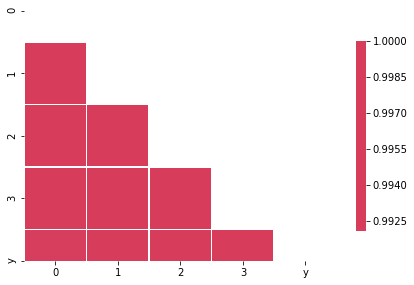

In [9]:
#create training dataframe to check correlation
df_y = pd.DataFrame(y_train[:,0],columns = ['y'])
df_x = pd.DataFrame(x_train[:,:,0])
df = pd.concat([df_x, df_y], axis=1)

corr_matrix_1 = df.corr()
f, ax = plt.subplots(figsize=(7, 7))
cmap = sns.diverging_palette(240, 5, as_cmap=True)
mask = np.triu(np.ones_like(corr_matrix_1, dtype=np.bool))
sns.heatmap(corr_matrix_1, mask= mask, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

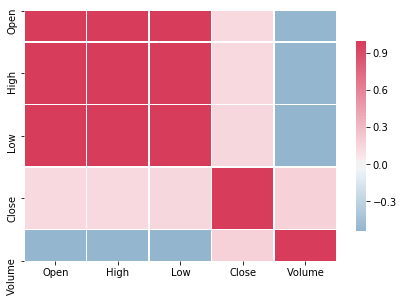

In [10]:
corr_matrix = data.corr()
f, ax = plt.subplots(figsize=(7, 7))
cmap = sns.diverging_palette(240, 5, as_cmap=True)
sns.heatmap(corr_matrix, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)

y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_val_lstm = torch.from_numpy(y_val).type(torch.Tensor)

y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_val_gru = torch.from_numpy(y_val).type(torch.Tensor)

y_train_rnn = torch.from_numpy(y_train).type(torch.Tensor)
y_val_rnn = torch.from_numpy(y_val).type(torch.Tensor)


#### Test data preprocessing

In [12]:
lookback = 5

def split_test(stock, lookback): 
    data = []

    for i in range(len(stock) - lookback): 
        data.append(stock[i: i + lookback])
    
    data = np.array(data);
    
    x_test = data[1253:,:-1,:]
    y_test = data[1253:,-1,:]
    
    return [x_test, y_test]

x_test, y_test = split_test(data_scaled, lookback)


In [13]:
x_test = torch.from_numpy(x_test).type(torch.Tensor)

y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)
y_test_rnn = torch.from_numpy(y_test).type(torch.Tensor)

x_test.shape

torch.Size([20, 4, 5])

### LSTM

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [15]:
input_dim = 5
hidden_dim = 64
num_layers = 1
output_dim = 5
num_epochs = 200

In [16]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [17]:
import time
start_time = time.time()

hist = np.zeros(num_epochs)
lstm = []
for t in range(num_epochs):
    y_train_pred_lstm = model(x_train)
    loss = criterion(y_train_pred_lstm, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
lstm_training_time = time.time()-start_time
print("Training time: {}".format(lstm_training_time))

Epoch  0 MSE:  0.33477672934532166
Epoch  1 MSE:  0.25209346413612366
Epoch  2 MSE:  0.17668598890304565
Epoch  3 MSE:  0.12244092673063278
Epoch  4 MSE:  0.1495458334684372
Epoch  5 MSE:  0.12078698724508286
Epoch  6 MSE:  0.07979124039411545
Epoch  7 MSE:  0.06363406777381897
Epoch  8 MSE:  0.05721060559153557
Epoch  9 MSE:  0.048599887639284134
Epoch  10 MSE:  0.04413408041000366
Epoch  11 MSE:  0.049547020345926285
Epoch  12 MSE:  0.04723625257611275
Epoch  13 MSE:  0.0352054163813591
Epoch  14 MSE:  0.02356410026550293
Epoch  15 MSE:  0.01684081368148327
Epoch  16 MSE:  0.013891296461224556
Epoch  17 MSE:  0.013327575288712978
Epoch  18 MSE:  0.014800895005464554
Epoch  19 MSE:  0.01744689606130123
Epoch  20 MSE:  0.019244637340307236
Epoch  21 MSE:  0.019065547734498978
Epoch  22 MSE:  0.01774187572300434
Epoch  23 MSE:  0.015905560925602913
Epoch  24 MSE:  0.01334584690630436
Epoch  25 MSE:  0.01058520283550024
Epoch  26 MSE:  0.008817935362458229
Epoch  27 MSE:  0.0085292253643

In [18]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred_lstm.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

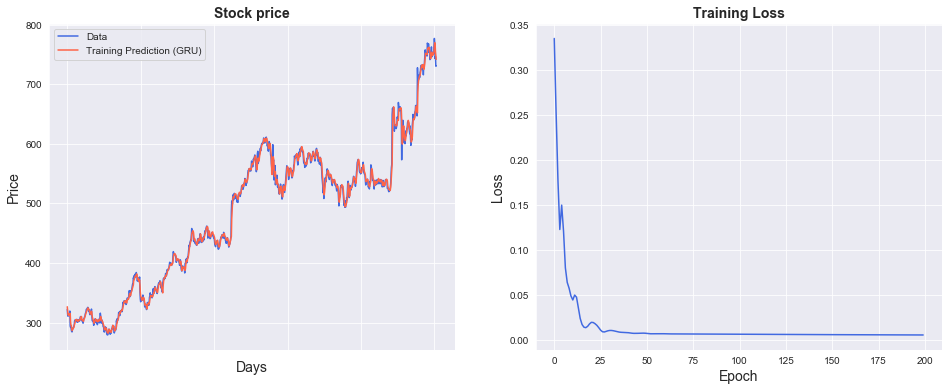

In [19]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [20]:
# make predictions with validation set
y_val_pred_lstm = model(x_val)
y_val_pred_lstm

#invert predictions
y_train_pred_lstm = scaler.inverse_transform(y_train_pred_lstm.detach().numpy())
y_train_lstm = scaler.inverse_transform(y_train_lstm.detach().numpy())

y_val_pred_lstm = scaler.inverse_transform(y_val_pred_lstm.detach().numpy())
y_val_lstm = scaler.inverse_transform(y_val_lstm.detach().numpy())

In [21]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
import math

lstm_train_error_list = [] 
for i in range(5):
    train_error_lstm  = math.sqrt(mean_squared_error(y_train_lstm[:,i], y_train_pred_lstm[:,i]))
    lstm_train_error_list.append(train_error_lstm)
    
lstm_val_error_list = []    
for i in range(5):
    val_error_lstm  = math.sqrt(mean_squared_error(y_val_lstm[:,i], y_val_pred_lstm[:,i]))
    lstm_val_error_list.append(val_error_lstm)

In [22]:
print(lstm_train_error_list)
print(lstm_val_error_list)

[7.542690593978012, 8.39918964655222, 8.348077116350048, 23.398415327618878, 1735720.2496808062]
[9.409574915885216, 9.848700159738126, 11.687734346539257, 11.593630890350084, 779628.3195677283]


In [23]:
# make predictions with test set
y_test_pred_lstm = model(x_test)

# invert predictions
y_test_pred_lstm = scaler.inverse_transform(y_test_pred_lstm.detach().numpy())
y_test_lstm = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
lstm_test_error_list = []
for i in range(5):
    test_error_lstm  = math.sqrt(mean_squared_error(y_test_lstm[:,i], y_test_pred_lstm[:,i]))
    lstm_test_error_list.append(test_error_lstm)
    
print(lstm_test_error_list)
print(y_test_pred_lstm)

[8.344913015855079, 8.779029864196005, 11.71270026134492, 11.106950841460897, 620226.2420762281]
[[7.8736731e+02 7.9379584e+02 7.7880017e+02 7.8621320e+02 1.6642096e+06]
 [7.8274823e+02 7.8941455e+02 7.7426196e+02 7.8089856e+02 1.7910450e+06]
 [7.8187177e+02 7.8896277e+02 7.7338953e+02 7.8301678e+02 1.8602389e+06]
 [7.8443506e+02 7.9121899e+02 7.7570209e+02 7.8559290e+02 1.7830378e+06]
 [7.8710199e+02 7.9386304e+02 7.7834357e+02 7.9099615e+02 1.8150011e+06]
 [7.9326367e+02 8.0021063e+02 7.8428540e+02 8.0008331e+02 1.8527124e+06]
 [8.0000262e+02 8.0673792e+02 7.9072229e+02 8.0569598e+02 1.7986056e+06]
 [8.0360425e+02 8.1016241e+02 7.9426385e+02 8.0782281e+02 1.7618380e+06]
 [8.0489514e+02 8.1151385e+02 7.9565961e+02 8.0861969e+02 1.7361286e+06]
 [8.0505469e+02 8.1173773e+02 7.9578760e+02 8.0862750e+02 1.7592781e+06]
 [8.0630969e+02 8.1299292e+02 7.9694843e+02 8.0935675e+02 1.7240002e+06]
 [8.0554407e+02 8.1217249e+02 7.9625555e+02 8.0887317e+02 1.7616148e+06]
 [8.0493091e+02 8.1161859e+

In [24]:
Error_test_pct_list_lstm = []

for i in range(5):
    Error_test_pct_lstm = abs(y_test_lstm[:,i] - y_test_pred_lstm[:,i])
    Error_test_pct_lstm = np.mean(Error_test_pct_lstm)
    Error_test_pct_lstm = Error_test_pct_lstm/(y_test_pred_lstm[:,i].mean())
    Error_test_pct_list_lstm.append(Error_test_pct_lstm)

print('LSTM test - (MAPE):', Error_test_pct_list_lstm)     

LSTM test - (MAPE): [0.007868959, 0.008731169, 0.012809255, 0.0097738905, 0.2907821]


### GRU

In [25]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [26]:
input_dim = 5
hidden_dim = 64
num_layers = 1
output_dim = 5
num_epochs = 200

In [27]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [28]:
start_time = time.time()

hist = np.zeros(num_epochs)

for t in range(num_epochs):
    y_train_pred_gru = model(x_train)

    loss = criterion(y_train_pred_gru, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
gru_training_time = time.time()-start_time    
print("GRU_Training time: {}".format(gru_training_time))

Epoch  0 MSE:  0.3335552215576172
Epoch  1 MSE:  0.20646098256111145
Epoch  2 MSE:  0.11508850753307343
Epoch  3 MSE:  0.09037748724222183
Epoch  4 MSE:  0.08081897348165512
Epoch  5 MSE:  0.04597437009215355
Epoch  6 MSE:  0.031440116465091705
Epoch  7 MSE:  0.029354378581047058
Epoch  8 MSE:  0.0317864790558815
Epoch  9 MSE:  0.03224003687500954
Epoch  10 MSE:  0.026383453980088234
Epoch  11 MSE:  0.019576584920287132
Epoch  12 MSE:  0.015081800520420074
Epoch  13 MSE:  0.012409494258463383
Epoch  14 MSE:  0.01171880029141903
Epoch  15 MSE:  0.01321644987910986
Epoch  16 MSE:  0.015400514006614685
Epoch  17 MSE:  0.016359645873308182
Epoch  18 MSE:  0.015610974282026291
Epoch  19 MSE:  0.01371049415320158
Epoch  20 MSE:  0.011367404833436012
Epoch  21 MSE:  0.00925039779394865
Epoch  22 MSE:  0.007904887199401855
Epoch  23 MSE:  0.007546843960881233
Epoch  24 MSE:  0.008012121543288231
Epoch  25 MSE:  0.008870289660990238
Epoch  26 MSE:  0.009578225202858448
Epoch  27 MSE:  0.0097011

In [29]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred_gru.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

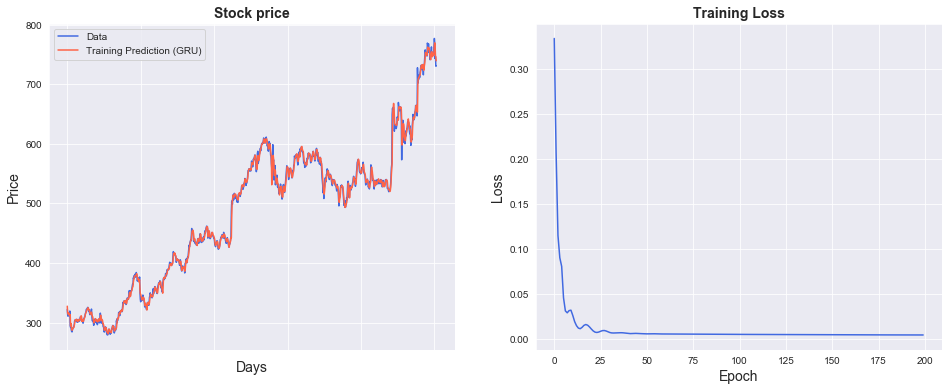

In [30]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [31]:
# make predictions
y_val_pred_gru = model(x_val)

In [32]:
# invert predictions

y_train_pred_gru = scaler.inverse_transform(y_train_pred_gru.detach().numpy())
y_train_gru = scaler.inverse_transform(y_train_gru.detach().numpy())

y_val_pred_gru = scaler.inverse_transform(y_val_pred_gru.detach().numpy())
y_val_gru = scaler.inverse_transform(y_val_gru.detach().numpy())


In [33]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
import math

gru_train_error_list = [] 
for i in range(5):
    train_error_gru = (np.square(y_train_gru[:,i]-y_train_pred_gru[:,i])).mean()
    train_error_gru = np.sqrt(train_error_gru)
    gru_train_error_list.append(train_error_gru)

gru_val_error_list = []    
for i in range(5):
    val_error_gru = (np.square(y_val_gru[:,i]-y_val_pred_gru[:,i])).mean()
    val_error_gru = np.sqrt(val_error_gru)
    gru_val_error_list.append(val_error_gru)


In [34]:
print(gru_train_error_list)
print(gru_val_error_list)

[7.070028, 7.7049623, 8.088295, 21.60602, 1675072.5]
[8.935039, 8.705131, 11.518511, 9.642652, 717985.7]


In [35]:
# make predictions
y_test_pred_gru = model(x_test)

In [36]:
y_test_pred_gru = y_test_pred_gru.detach().numpy()
y_test_pred_gru = scaler.inverse_transform(y_test_pred_gru)


In [37]:
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [38]:
y_test_gru = y_test_gru.detach().numpy()
y_test_gru = scaler.inverse_transform(y_test_gru)


In [39]:
gru_test_error_list = []
for i in range(5):
    data_list = ['open', 'high', 'low', 'close', 'volume']
    test_error_gru = (np.square(y_test_gru[:,i]-y_test_pred_gru[:,i])).mean()
    test_error_gru = np.sqrt(test_error_gru)
    gru_test_error_list.append(test_error_gru)
    
print(gru_test_error_list)
print(y_test_pred_gru)

[10.089408, 9.52996, 14.134038, 10.037941, 574562.2]
[[7.8178290e+02 7.8690802e+02 7.7354889e+02 7.8050720e+02 1.5714749e+06]
 [7.7749640e+02 7.8236060e+02 7.6859564e+02 7.7420465e+02 1.8306582e+06]
 [7.7883588e+02 7.8439069e+02 7.6923242e+02 7.8133331e+02 1.9024434e+06]
 [7.8230902e+02 7.8878766e+02 7.7370496e+02 7.8449072e+02 1.7418512e+06]
 [7.8486816e+02 7.9121503e+02 7.7581744e+02 7.8972968e+02 1.7748788e+06]
 [7.9199146e+02 7.9862671e+02 7.8209625e+02 8.0181024e+02 1.8674081e+06]
 [7.9812585e+02 8.0524438e+02 7.8903552e+02 8.0485718e+02 1.7922772e+06]
 [8.0026373e+02 8.0689777e+02 7.9127271e+02 8.0210236e+02 1.7336328e+06]
 [8.0011554e+02 8.0618860e+02 7.9086841e+02 8.0220599e+02 1.7132754e+06]
 [7.9976282e+02 8.0561206e+02 7.9042847e+02 8.0294214e+02 1.7872036e+06]
 [8.0166241e+02 8.0812903e+02 7.9257404e+02 8.0386670e+02 1.7243842e+06]
 [8.0028735e+02 8.0616449e+02 7.9102191e+02 8.0172931e+02 1.7775399e+06]
 [7.9956250e+02 8.0547906e+02 7.9028015e+02 8.0146002e+02 1.7900954e+06

In [40]:
Error_train_pct_list = []

for i in range(5):
    Error_train_pct_gru = abs(y_train_gru[:,i] - y_train_pred_gru[:,i])
    Error_train_pct_gru = np.mean(Error_train_pct_gru)
    Error_train_pct_gru = Error_train_pct_gru/(y_train_pred_gru[:,i].mean())
    Error_train_pct_list.append(Error_train_pct_gru)
    
print('GRU Train -(MAPE):', Error_train_pct_list)        

GRU Train -(MAPE): [0.008646331, 0.009792373, 0.011112309, 0.011937317, 0.26391485]


In [41]:
Error_val_pct_list = []

for i in range(5):
    Error_val_pct_gru = abs(y_val_gru[:,i] - y_val_pred_gru[:,i])
    Error_val_pct_gru = np.mean(Error_val_pct_gru)
    Error_val_pct_gru = Error_val_pct_gru/(y_val_pred_gru[:,i].mean())
    Error_val_pct_list.append(Error_val_pct_gru)

print('GRU val - (MAPE):', Error_val_pct_list)        

GRU val - (MAPE): [0.008601385, 0.008487741, 0.0122927865, 0.009532068, 0.27322212]


In [42]:
Error_test_pct_list = []

for i in range(5):
    Error_test_pct_gru = abs(y_test_gru[:,i] - y_test_pred_gru[:,i])
    Error_test_pct_gru = np.mean(Error_test_pct_gru)
    Error_test_pct_gru = Error_test_pct_gru/(y_test_pred_gru[:,i].mean())
    Error_test_pct_list.append(Error_test_pct_gru)

print('GRU test - (MAPE):', Error_test_pct_list)     

GRU test - (MAPE): [0.01095185, 0.009548475, 0.01654597, 0.010148478, 0.27130783]


### Tanh (Vanilla) RNN

In [43]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.RNN = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.RNN(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [44]:
input_dim = 5
hidden_dim = 64
num_layers = 1
output_dim = 5
num_epochs = 200

In [45]:
model = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [46]:
start_time = time.time()

hist = np.zeros(num_epochs)
rnn = []

for t in range(num_epochs):
    y_train_pred_rnn = model(x_train)

    loss = criterion(y_train_pred_rnn, y_train_rnn)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
rnn_training_time = time.time()-start_time    
print("Training time: {}".format(rnn_training_time))

Epoch  0 MSE:  0.3836168348789215
Epoch  1 MSE:  0.14688947796821594
Epoch  2 MSE:  0.15260571241378784
Epoch  3 MSE:  0.060518719255924225
Epoch  4 MSE:  0.04525751248002052
Epoch  5 MSE:  0.07555406540632248
Epoch  6 MSE:  0.05414574220776558
Epoch  7 MSE:  0.030983053147792816
Epoch  8 MSE:  0.02384559065103531
Epoch  9 MSE:  0.0242402832955122
Epoch  10 MSE:  0.023951105773448944
Epoch  11 MSE:  0.02743738703429699
Epoch  12 MSE:  0.021300069987773895
Epoch  13 MSE:  0.021855762228369713
Epoch  14 MSE:  0.017628200352191925
Epoch  15 MSE:  0.014727515168488026
Epoch  16 MSE:  0.014166094362735748
Epoch  17 MSE:  0.011962514370679855
Epoch  18 MSE:  0.012052623555064201
Epoch  19 MSE:  0.014121434651315212
Epoch  20 MSE:  0.014099319465458393
Epoch  21 MSE:  0.012518292292952538
Epoch  22 MSE:  0.011822131462395191
Epoch  23 MSE:  0.011126699857413769
Epoch  24 MSE:  0.009537583217024803
Epoch  25 MSE:  0.0086976308375597
Epoch  26 MSE:  0.00887965876609087
Epoch  27 MSE:  0.0084067

In [47]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred_rnn.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_rnn.detach().numpy()))

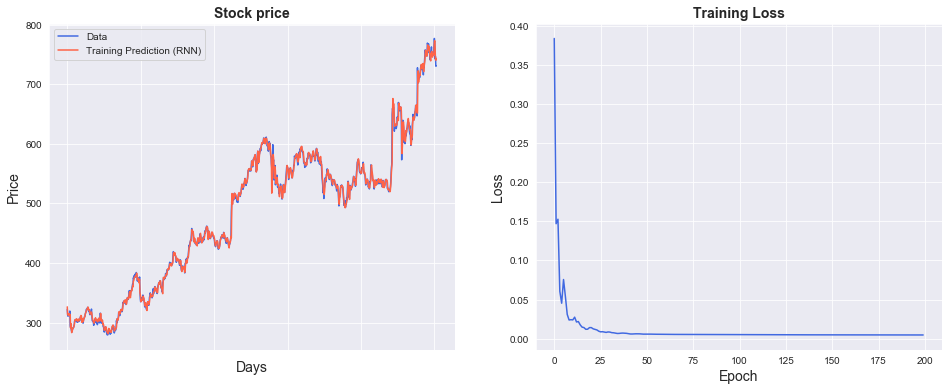

In [48]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (RNN)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [49]:
from sklearn.metrics import mean_squared_error

# make predictions
y_val_pred_rnn = model(x_val)

# invert predictions
y_train_pred_rnn = scaler.inverse_transform(y_train_pred_rnn.detach().numpy())
y_train_rnn = scaler.inverse_transform(y_train_rnn.detach().numpy())

y_val_pred_rnn = scaler.inverse_transform(y_val_pred_rnn.detach().numpy())
y_val_rnn = scaler.inverse_transform(y_val_rnn.detach().numpy())

rnn_train_error_list = [] 
for i in range(5):
    train_error_rnn = (np.square(y_train_rnn[:,i]-y_train_pred_rnn[:,i])).mean()
    train_error_rnn = np.sqrt(train_error_rnn)
    rnn_train_error_list.append(train_error_rnn)


rnn_val_error_list = []    
for i in range(5):
    val_error_rnn = (np.square(y_val_rnn[:,i]-y_val_pred_rnn[:,i])).mean()
    val_error_rnn = np.sqrt(val_error_rnn)
    rnn_val_error_list.append(val_error_rnn)


In [50]:
# make predictions
y_test_pred_rnn = model(x_test)

# invert predictions
y_test_pred_rnn = y_test_pred_rnn.detach().numpy()
y_test_pred_rnn = scaler.inverse_transform(y_test_pred_rnn)

y_test_rnn = y_test_rnn.detach().numpy()
y_test_rnn = scaler.inverse_transform(y_test_rnn)

rnn_test_error_list = []
for i in range(5):
    test_error_rnn = (np.square(y_test_rnn[:,i]-y_test_pred_rnn[:,i])).mean()
    test_error_rnn = np.sqrt(test_error_rnn)
    rnn_test_error_list.append(test_error_rnn)
    
print(rnn_test_error_list)
print(y_test_pred_rnn)

[8.072758, 9.084419, 13.505568, 9.118133, 604580.25]
[[7.8091956e+02 7.8505707e+02 7.6976617e+02 7.8209106e+02 1.5294341e+06]
 [7.7545880e+02 7.8148907e+02 7.6586285e+02 7.7365088e+02 2.0219754e+06]
 [7.8032397e+02 7.8474475e+02 7.7004602e+02 7.8312476e+02 1.8743698e+06]
 [7.8560193e+02 7.8954315e+02 7.7498029e+02 7.9071460e+02 1.7722012e+06]
 [7.8654425e+02 7.9125745e+02 7.7601270e+02 7.9468408e+02 1.9324361e+06]
 [7.9438300e+02 7.9935938e+02 7.8393231e+02 8.0667902e+02 2.0339580e+06]
 [8.0279828e+02 8.0672882e+02 7.9094580e+02 8.1206439e+02 1.9359374e+06]
 [8.0243134e+02 8.0706586e+02 7.9068317e+02 8.0772650e+02 1.9155361e+06]
 [8.0086993e+02 8.0538867e+02 7.8934106e+02 8.0724097e+02 1.8157780e+06]
 [8.0048584e+02 8.0536047e+02 7.8925238e+02 8.0737408e+02 1.9555156e+06]
 [8.0426202e+02 8.0837701e+02 7.9258411e+02 8.0964465e+02 1.7985864e+06]
 [8.0161816e+02 8.0633490e+02 7.9032190e+02 8.0699854e+02 2.0115199e+06]
 [8.0024255e+02 8.0466034e+02 7.8844165e+02 8.0545569e+02 1.8632780e+06

In [51]:
Error_test_pct_list_rnn = []

for i in range(5):
    Error_test_pct_rnn = abs(y_test_rnn[:,i] - y_test_pred_rnn[:,i])
    Error_test_pct_rnn = np.mean(Error_test_pct_rnn)
    Error_test_pct_rnn = Error_test_pct_rnn/(y_test_pred_rnn[:,i].mean())
    Error_test_pct_list_rnn.append(Error_test_pct_rnn)

print('Vanilla RNN test - (MAPE):', Error_test_pct_list_rnn)     

Vanilla RNN test - (MAPE): [0.008682283, 0.009019881, 0.01594848, 0.008096976, 0.26787716]


### Model Comparison

#### Train error comparison

In [52]:
gru_train_error_list = [round(num, 3) for num in gru_train_error_list]
gru_train_error_list = pd.DataFrame(gru_train_error_list, columns=['gru'])

lstm_train_error_list = [round(num, 3) for num in lstm_train_error_list]
lstm_train_error_list = pd.DataFrame(lstm_train_error_list, columns=['lstm'])

rnn_train_error_list = [round(num, 3) for num in rnn_train_error_list]
rnn_train_error_list = pd.DataFrame(rnn_train_error_list, columns=['rnn'])

train_error = pd.concat([gru_train_error_list, lstm_train_error_list, rnn_train_error_list], axis=1)
train_error.rename({0: 'open', 1: 'high', 2:'low', 3:'close', 4:'volume'}, axis='index')

,gru,lstm,rnn
open,7.070000e+00,7.543,6.832
high,7.705000e+00,8.399,7.634
low,8.088000e+00,8.348,7.583
close,2.160600e+01,23.398,21.850
volume,1.675072e+06,1735720.250,1661811.875


(0, 50)

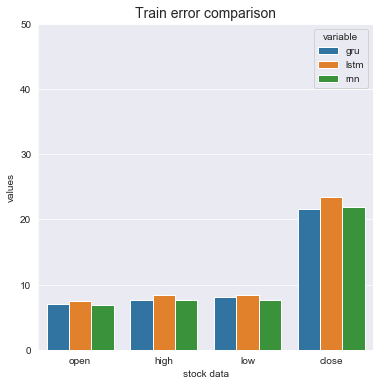

In [53]:
train_error = train_error.iloc[:4,:]
train_error.index  = ["open", "high", "low", 'close']
df_plot = train_error.reset_index().rename({'index': 'stock data'}, axis=1)
df_plot = df_plot.melt(id_vars='stock data')

fig,ax = plt.subplots(figsize=(6,6))
sns.barplot('stock data', 'value', hue='variable', data=df_plot, ax=ax)
plt.title('Train error comparison', fontsize= 14)
plt.xlabel('stock data')
plt.ylabel('values')
plt.ylim(0,50)

#### Validation error comparison

In [54]:
lstm_val_error_list = [round(num, 3) for num in lstm_val_error_list]
lstm_val_error_list = pd.DataFrame(lstm_val_error_list, columns=['lstm'])

gru_val_error_list = [round(num, 3) for num in gru_val_error_list]
gru_val_error_list = pd.DataFrame(gru_val_error_list, columns=['gru'])

rnn_val_error_list = [round(num, 3) for num in rnn_val_error_list]
rnn_val_error_list = pd.DataFrame(rnn_val_error_list, columns=['rnn'])

val_error = pd.concat([gru_val_error_list, lstm_val_error_list, rnn_val_error_list], axis=1)
val_error.rename({0: 'open', 1: 'high', 2:'low', 3:'close', 4:'volume'}, axis='index')


,gru,lstm,rnn
open,8.9350,9.410,7.9800
high,8.7050,9.849,8.5550
low,11.5190,11.688,11.4500
close,9.6430,11.594,9.5870
volume,717985.6875,779628.320,725815.0625


(0, 50)

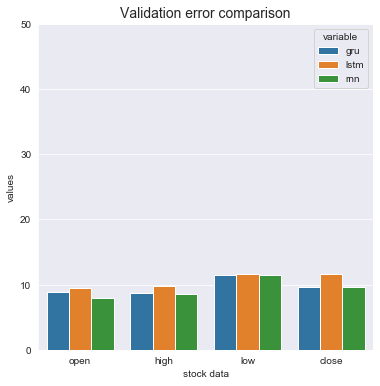

In [55]:
val_error = val_error.iloc[:4,:]
val_error.index  = ["open", "high", "low", 'close']
df_plot = val_error.reset_index().rename({'index': 'stock data'}, axis=1)
df_plot = df_plot.melt(id_vars='stock data')

fig,ax = plt.subplots(figsize=(6,6))
sns.barplot('stock data', 'value', hue='variable', data=df_plot, ax=ax)
plt.title('Validation error comparison', fontsize= 14)
plt.xlabel('stock data')
plt.ylabel('values')
plt.ylim(0,50)

#### Test error comparison


In [56]:
lstm_test_error_list = [round(num, 3) for num in lstm_test_error_list]
lstm_test_error_list = pd.DataFrame(lstm_test_error_list, columns=['lstm'])

gru_test_error_list = [round(num, 3) for num in gru_test_error_list]
gru_test_error_list = pd.DataFrame(gru_test_error_list, columns=['gru'])

rnn_test_error_list = [round(num, 3) for num in rnn_test_error_list]
rnn_test_error_list = pd.DataFrame(rnn_test_error_list, columns=['rnn'])

test_error = pd.concat([gru_test_error_list, lstm_test_error_list, rnn_test_error_list], axis=1)
test_error.rename({0: 'open', 1: 'high', 2:'low', 3:'close', 4:'volume'}, axis='index')

,gru,lstm,rnn
open,10.0890,8.345,8.073
high,9.5300,8.779,9.084
low,14.1340,11.713,13.506
close,10.0380,11.107,9.118
volume,574562.1875,620226.242,604580.250


(0, 50)

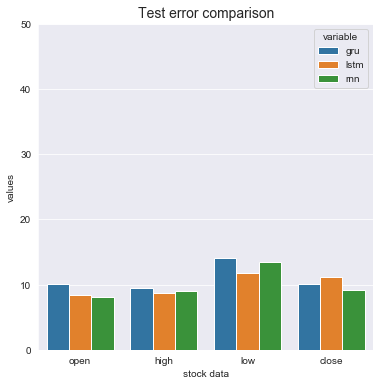

In [57]:
test_error = test_error.iloc[:4,:]
test_error.index  = ["open", "high", "low", 'close']
df_plot = test_error.reset_index().rename({'index': 'stock data'}, axis=1)
df_plot = df_plot.melt(id_vars='stock data')

fig,ax = plt.subplots(figsize=(6,6))
sns.barplot('stock data', 'value', hue='variable', data=df_plot, ax=ax)
plt.title('Test error comparison', fontsize= 14)
plt.xlabel('stock data')
plt.ylabel('values')
plt.ylim(0,50)

#### Comparision of predicted vs actual value

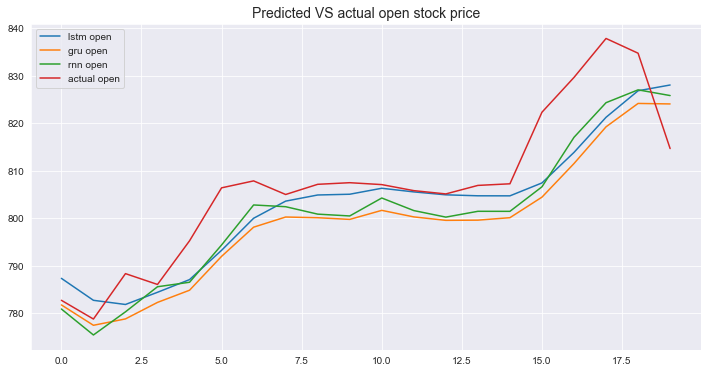

In [58]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,0], label='lstm open');
plt.plot(y_test_pred_gru[:,0], label='gru open');
plt.plot(y_test_pred_rnn[:,0], label='rnn open');
plt.plot(y_test_lstm[:,0], label='actual open');
plt.title('Predicted VS actual open stock price', fontsize=14)
plt.legend()

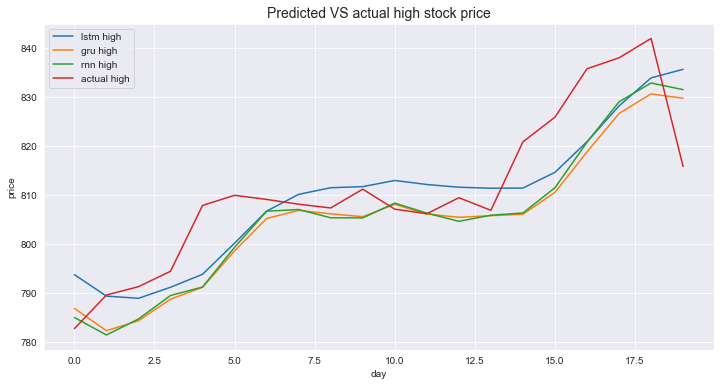

In [59]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,1], label='lstm high');
plt.plot(y_test_pred_gru[:,1], label='gru high');
plt.plot(y_test_pred_rnn[:,1], label='rnn high');
plt.plot(y_test_lstm[:,1], label='actual high');
plt.title('Predicted VS actual high stock price', fontsize=14)
plt.xlabel('day')
plt.ylabel('price')
plt.legend()

In [60]:
y_test_pred_lstm.shape

(20, 5)

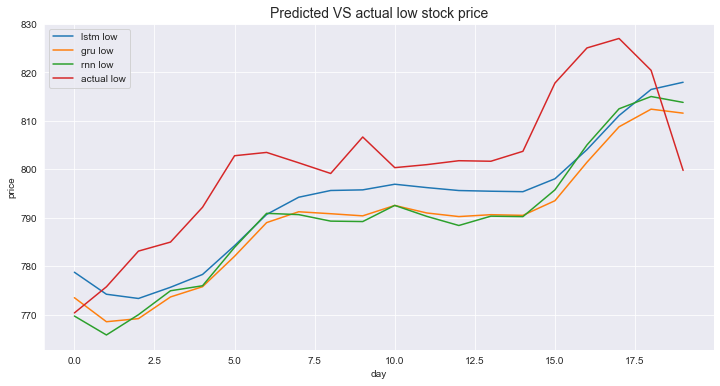

In [61]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,2], label='lstm low');
plt.plot(y_test_pred_gru[:,2], label='gru low');
plt.plot(y_test_pred_rnn[:,2], label='rnn low');
plt.plot(y_test_lstm[:,2], label='actual low');
plt.title('Predicted VS actual low stock price', fontsize=14)
plt.xlabel('day')
plt.ylabel('price')
plt.legend()

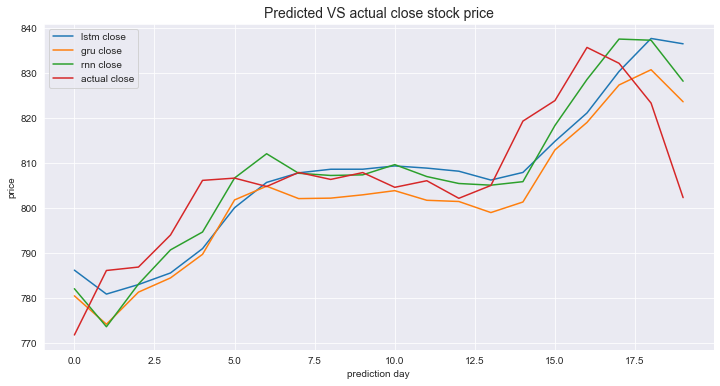

In [62]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,3], label='lstm close');
plt.plot(y_test_pred_gru[:,3], label='gru close');
plt.plot(y_test_pred_rnn[:,3], label='rnn close');
plt.plot(y_test_lstm[:,3], label='actual close');
plt.title('Predicted VS actual close stock price', fontsize=14)
plt.xlabel('prediction day')
plt.ylabel('price')
plt.legend()

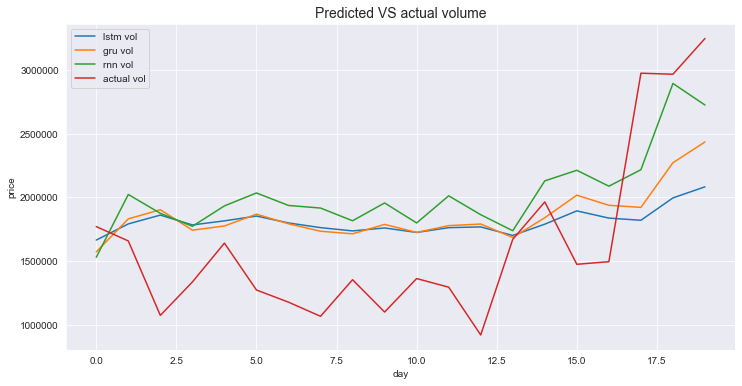

In [63]:
plt.figure(figsize=(12,6))
plt.plot(y_test_pred_lstm[:,4], label='lstm vol');
plt.plot(y_test_pred_gru[:,4], label='gru vol');
plt.plot(y_test_pred_rnn[:,4], label='rnn vol');
plt.plot(y_test_lstm[:,4], label='actual vol');
plt.title('Predicted VS actual volume', fontsize=14)
plt.xlabel('day')
plt.ylabel('price')
plt.legend()